In [5]:
import org.apache.spark.sql.expressions._ 
import org.apache.spark.sql.functions._
import vegas._
import vegas.render.WindowRenderer._
import vegas.sparkExt._

implicit val render = vegas.render.ShowHTML(kernel.display.content("text/html", _))

render = <function1>


<function1>

Load exit events from the database.

In [6]:
val exits = spark.read.parquet("/user/awight/exits")
    .filter($"row_count" =!= lit(-1)) // Drop any data missing the row count.

exits = [exit_timestamp: timestamp, start_time_ts_ms: bigint ... 10 more fields]


[exit_timestamp: timestamp, start_time_ts_ms: bigint ... 10 more fields]

Summary statistics

In [7]:
exits.select("row_count").summary().show()

+-------+------------------+
|summary|         row_count|
+-------+------------------+
|  count|              5154|
|   mean| 7.053162592161428|
| stddev|13.550384902330627|
|    min|                 1|
|    25%|                 3|
|    50%|                 3|
|    75%|                 7|
|    max|               233|
+-------+------------------+



Plot the mean row count for each outcome.

In [ ]:
val sanitized = exits.select("exit_action", "row_count")
Vegas("Action vs row count")
  .withDataFrame(sanitized)
  .mark(Point)
  .encodeX("row_count", Quantitative, AggOps.Mean)
  .encodeY("exit_action", Nominal)
  .encodeColor("exit_action", Nominal)
  .encodeSize(aggregate=AggOps.Count, field="*", dataType=Quantitative)
.show

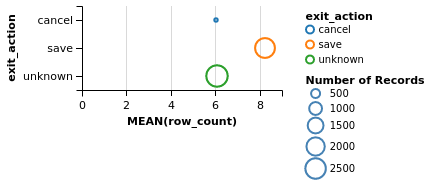

Show how the exit success rate varies with row count.

In [ ]:
// TODO!
// Vegas("Row count vs outcome")
//   .withDataFrame(sanitized)
//   .mark(Line)
//   .encodeX("row_count", Quantitative, enableBin=true)
//   .encodeColor("exit_action", Nominal)
//   .encodeY(aggregate=AggOps.Count, field="row_count", dataType=Quantitative)
// .show
//

Does the row count vary per namespace?

In [ ]:
val sanitized = exits.select("page_namespace", "row_count")
Vegas("Namespace vs row count")
  .withDataFrame(sanitized)
  .mark(Point)
  .encodeX("page_namespace", Nominal)
  .encodeSize(aggregate=AggOps.Count, field="*", dataType=Quantitative)
  .encodeY("row_count", Quantitative, AggOps.Mean)
.show

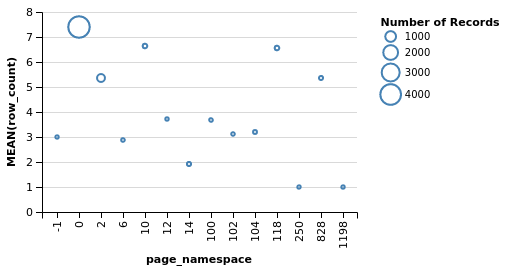

Show all events, sorted by row count.  This gives some sense of the distribution.

In [ ]:
val w = Window.orderBy("row_count")
val sanitized_ordered = sanitized.withColumn("row_count_rank", rank().over(w))

Vegas("Row count distribution")
  .withDataFrame(sanitized_ordered)
      .mark(Line)
      .encodeX("row_count_rank", Quantitative)
      .encodeY("row_count", Quantitative)
  .show

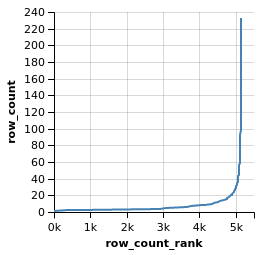

Zoom in on the low row-count range.

In [11]:
val low20_counts = exits.groupBy("row_count").count().filter($"row_count" <= lit(20)).orderBy("row_count")
low20_counts.show()

+---------+-----+
|row_count|count|
+---------+-----+
|        1|  379|
|        2|  428|
|        3| 2099|
|        4|  174|
|        5|  587|
|        6|  111|
|        7|  293|
|        8|   81|
|        9|  200|
|       10|   44|
|       11|  124|
|       12|   39|
|       13|  104|
|       14|   24|
|       15|   62|
|       16|   13|
|       17|   57|
|       18|   12|
|       19|   37|
|       20|   15|
+---------+-----+



low20_counts = [row_count: int, count: bigint]


[row_count: int, count: bigint]

In [ ]:
Vegas("Row count distribution (<= 20 rows)")
  .withDataFrame(low20_counts)
      .mark(Line)
      .encodeX("row_count", Ordinal)
      .encodeY("count", Quantitative)
  .show

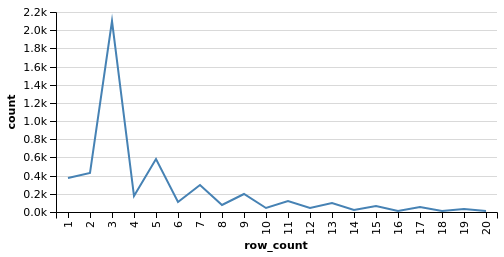

In [13]:
exits.cache()
val binned = exits.withColumn("row_bin", lit(10) * ceil($"row_count" / lit(10)))
      .groupBy("row_bin", "exit_action").count()

binned = [row_bin: bigint, exit_action: string ... 1 more field]


[row_bin: bigint, exit_action: string ... 1 more field]

In [ ]:
Vegas("Row count distribution (bins of 10 rows)")
    .withDataFrame(binned)
    .mark(Bar)
    .encodeX("row_bin", Ordinal)
    .encodeY(aggregate=AggOps.Sum, field="count", dataType=Quantitative)
    .encodeColor("exit_action", Nominal)
    .show

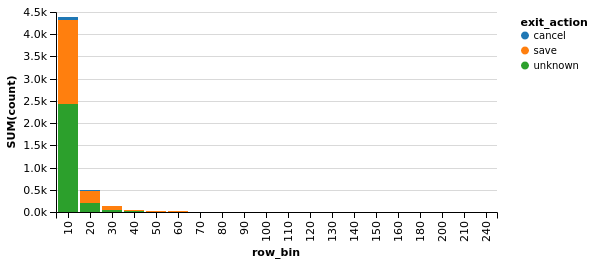